# **Análise de sobrevivencia aplicada ao RH como forma de prevenção de desligamentos voluntários**

Para realizar o experimento será utilizado um DataFrame baseado na base de dados com informações fictícias de empregados da IBM - [**IBM HR Analytics Employee Attrition & Performance**](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) a base de dados é pública e pode ser encontrada no [kaggle](https://kaggle.com)

## Bibliotecas

In [106]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from lifelines import NelsonAalenFitter

from warnings import filterwarnings
filterwarnings('ignore')

## Funções

In [85]:
#Retorna a Estatistica Descritiva de uma variável
def desc_estats(df, var, tipo='hist'):
    print('\n\033[1mEstatística Descritiva\033[0m')
    print('\nEmpregados Ativos\n')
    print('Mínimo - {}'.format(df[df['desligamento']==0][var].min()))
    print('Máximo - {}'.format(df[df['desligamento']==0][var].max()))
    print('Amplitude - {}'.format(df[df['desligamento']==0][var].max() - df[df['desligamento']==0][var].min()))
    print('Média - {}'.format(round(df[df['desligamento']==0][var].mean(),2)))
    print('Mediana - {}'.format(int(df[df['desligamento']==0][var].median())))
    print('Moda - {}'.format(int(df[df['desligamento']==0][var].mode().mean())))
    if tipo=='hist':
        print('Desvio Padrão - {}'.format(round(df[df['desligamento']==0][var].std(),2)))
        print('Intervalo com 95% de confianca: Inferior {}, Superior {}'.format(round(df[df['desligamento']==0][var].mean() - (df[df['desligamento']==0][var].std() * 2),2),
                                                                                round(df[df['desligamento']==0][var].mean() + (df[df['desligamento']==0][var].std() * 2),2)))
    print('\nEmpregados Desligados\n')
    print('Mínimo - {}'.format(df[df['desligamento']==1][var].min()))
    print('Máximo - {}'.format(df[df['desligamento']==1][var].max()))
    print('Amplitude - {}'.format(df[df['desligamento']==1][var].max() - df[df['desligamento']==1][var].min()))
    print('Média - {}'.format(round(df[df['desligamento']==1][var].mean(),2)))
    print('Mediana - {}'.format(int(df[df['desligamento']==1][var].median())))
    print('Moda - {}'.format(int(df[df['desligamento']==1][var].mode().mean())))
    if tipo=='hist':
        print('Desvio Padrão - {}'.format(round(df[df['desligamento']==1][var].std(),2)))
        print('Intervalo com 95% de confianca: Inferior {}, Superior {}'.format(round(df[df['desligamento']==1][var].mean() - (df[df['desligamento']==1][var].std() * 2),2), 
                                                                                round(df[df['desligamento']==1][var].mean() + (df[df['desligamento']==1][var].std() * 2),2)))
    if tipo=='hist':    
        print('\n\033[1mHistograma das Distribuições\033[0m')
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df[df['desligamento']==0][var],  fit=stats.norm, ax=axes[0])
        axes[0].set_title(f'Distribuição {var} - Empregados Ativos')
        sns.distplot(df[df['desligamento']==1][var],  fit=stats.norm, ax=axes[1])
        axes[1].set_title(f'Distribuição {var} - Empregados Desligados')        
        plt.show()
        
        print('\n\033[1mTestes para toda Distribuição\033[0m')
        print('\n\033[1mShapiro Teste Para Determinar a Normalidade\033[0m')
        print('Teste Estatistico - {}'.format(round(stats.shapiro(df[var]).statistic,3)))
        print('P-Value- {}'.format(round(stats.shapiro(df[var]).pvalue,3)))

        print('\n\033[1mTeste de distorção para determinar a inclinação da curva\033[0m')
        print('Skewness - {}'. format(round(stats.skew(df[var]),3)))

        print('\n\033[1mTeste de curtose para determinar a inclinação das extremidades da curva\033[0m')
        print('Kurtosis - {}'. format(round(stats.kurtosis(df[var]),3)))    
        
    elif tipo=='bar':
        print('\n\033[1mDistribuição dos valores\033[0m')
        sns.catplot(x=var, kind='count', data=df[df['desligamento']==0], aspect=1.5, palette='cool')
        plt.title(f'Distribuição {var} - Empregados Ativos')
        plt.show()
        
        sns.catplot(x=var, kind='count', data=df[df['desligamento']==1], aspect=1.5, palette='cool')
        plt.title(f'Distribuição {var} - Empregados Desligados')        
        plt.show()
    
def desc_quali(df, var):
    print('\n\033[1mDistribuição dos valores\033[0m')
    sns.catplot(y=var, kind='count', data=df[df['desligamento']==0], aspect=1.5, palette='cool', orient="h", order=list(set(df[var].sort_values())))
    plt.title(f'Distribuição {var} - Empregados Ativos')
    plt.show()
    
    sns.catplot(y=var, kind='count', data=df[df['desligamento']==1], aspect=1.5, palette='cool', orient="h", order=list(set(df[var].sort_values())))
    plt.title(f'Distribuição {var} - Empregados Desligados')
    plt.show()

def desc_quali_target(df, var):
    print('\n\033[1mDistribuição dos valores\033[0m')
    ax = sns.catplot(y=var, kind='count', data=df, aspect=1.5, palette='cool', orient="h")
    plt.title(f'Distribuição {var}')
    plt.show()
    
    print('\n\033[1mDistribuição dos valores tabela\033[0m')
    print(df[var].value_counts())

In [80]:
list(set(df['genero'].sort_values()))

['Male', 'Female']

## Importando dados dos empregados

In [19]:
df = pd.read_csv('data/ibm_df_attrition.csv')
df.head()

,idade,desligamento,frequencia_viagens,departamento,distancia_casa,nivel_educacao,campo_educacao,satistacao_ambiente,genero,nivel_habilidades,...,avaliacao_entregas,satisfacao_colegas,acoes_empresa,treinamentos_ultimo_ano,satisfacao_qualidade_vida,meses_empresa,meses_gerencia_atual,meses_ultima_promocao,meses_cargo,meses_trabalhados
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,...,3,1,0,0,1,79,69,1,55,105
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,...,4,4,1,3,3,131,88,23,95,131
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,...,3,2,0,3,3,9,1,9,7,91
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,...,3,3,0,3,3,101,2,37,93,104
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,...,3,4,1,3,3,28,35,33,26,79


## Informações do daframe

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   idade                      1470 non-null   int64 
 1   desligamento               1470 non-null   int64 
 2   frequencia_viagens         1470 non-null   object
 3   departamento               1470 non-null   object
 4   distancia_casa             1470 non-null   int64 
 5   nivel_educacao             1470 non-null   int64 
 6   campo_educacao             1470 non-null   object
 7   satistacao_ambiente        1470 non-null   int64 
 8   genero                     1470 non-null   object
 9   nivel_habilidades          1470 non-null   int64 
 10  nivel_cargo                1470 non-null   int64 
 11  cargo                      1470 non-null   object
 12  satisfacao_cargo           1470 non-null   int64 
 13  estado_civil               1470 non-null   object
 14  salario_

_O dataframe possui 1470 registros de empregados, cada registro possui 28 características_

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
idade,1470.0,36.923810,9.135373,18.0,30.0,36.0,43.00,60.0
desligamento,1470.0,0.161224,0.367863,0.0,0.0,0.0,0.00,1.0
distancia_casa,1470.0,9.192517,8.106864,1.0,2.0,7.0,14.00,29.0
nivel_educacao,1470.0,2.912925,1.024165,1.0,2.0,3.0,4.00,5.0
satistacao_ambiente,1470.0,2.721769,1.093082,1.0,2.0,3.0,4.00,4.0
nivel_habilidades,1470.0,2.729932,0.711561,1.0,2.0,3.0,3.00,4.0
nivel_cargo,1470.0,2.063946,1.106940,1.0,1.0,2.0,3.00,5.0
satisfacao_cargo,1470.0,2.728571,1.102846,1.0,2.0,3.0,4.00,4.0
salario_mensal,1470.0,6502.931293,4707.956783,1009.0,2911.0,4919.0,8379.00,19999.0
empresas_trabalhadas,1470.0,2.693197,2.498009,0.0,1.0,2.0,4.00,9.0


## Analisando as Features Quantidativas do DataFrame

---
### Idades


Estatística Descritiva

Empregados Ativos

Mínimo - 18
Máximo - 60
Amplitude - 42
Média - 37.56
Mediana - 36
Moda - 34
Desvio Padrão - 8.89
Intervalo com 95% de confianca: Inferior 19.78, Superior 55.34

Empregados Desligados

Mínimo - 18
Máximo - 58
Amplitude - 40
Média - 33.61
Mediana - 32
Moda - 30
Desvio Padrão - 9.69
Intervalo com 95% de confianca: Inferior 14.23, Superior 52.99

Histograma das Distribuições


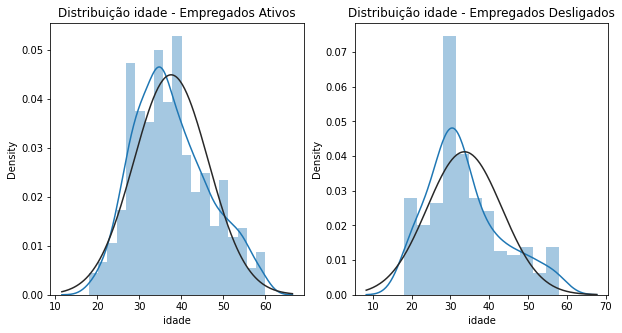


Testes para toda Distribuição

Shapiro Teste Para Determinar a Normalidade
Teste Estatistico - 0.977
P-Value- 0.0

Teste de distorção para determinar a inclinação da curva
Skewness - 0.413

Teste de curtose para determinar a inclinação das extremidades da curva
Kurtosis - -0.407


In [40]:
desc_estats(df=df, var='idade', tipo='hist')

---
### Distância Casa


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 29
Amplitude - 28
Média - 8.92
Mediana - 7
Moda - 2

Empregados Desligados

Mínimo - 1
Máximo - 29
Amplitude - 28
Média - 10.63
Mediana - 9
Moda - 2

Distribuição dos valores


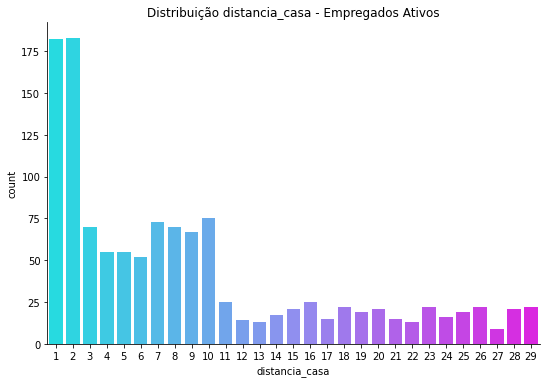

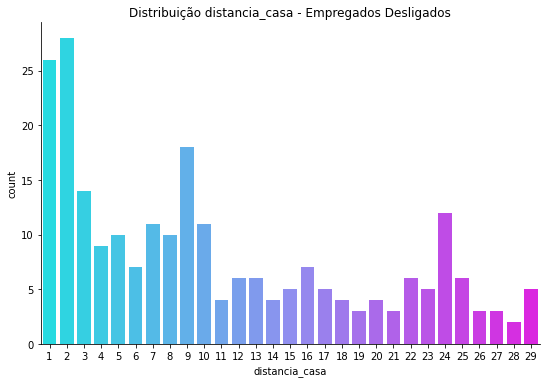

In [42]:
desc_estats(df=df, tipo='bar', var='distancia_casa')

---
### Nível Educação


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 5
Amplitude - 4
Média - 2.93
Mediana - 3
Moda - 3

Empregados Desligados

Mínimo - 1
Máximo - 5
Amplitude - 4
Média - 2.84
Mediana - 3
Moda - 3

Distribuição dos valores


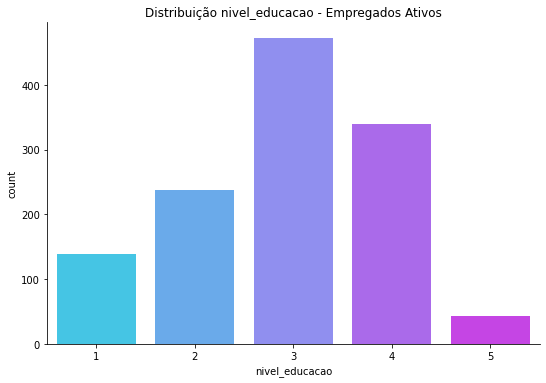

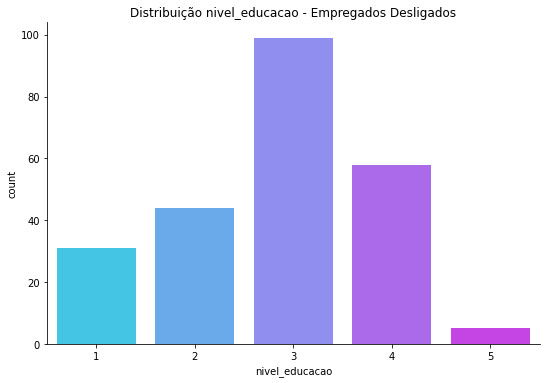

In [43]:
desc_estats(df=df, tipo='bar', var='nivel_educacao')

---
### Satisfação Ambiente


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.77
Mediana - 3
Moda - 3

Empregados Desligados

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.46
Mediana - 3
Moda - 1

Distribuição dos valores


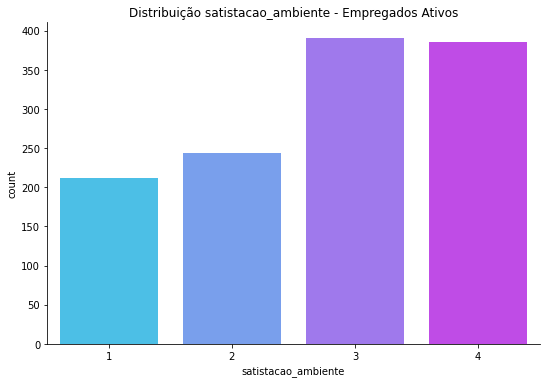

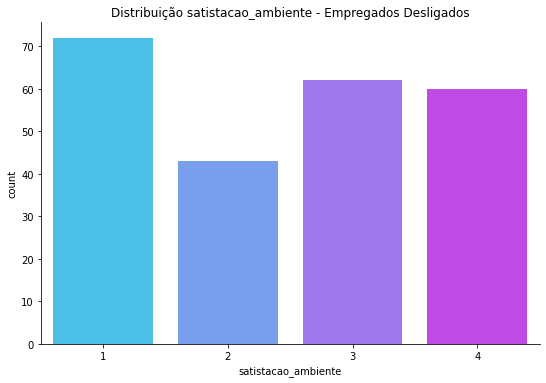

In [44]:
desc_estats(df=df, tipo='bar', var='satistacao_ambiente')

---
### Nível das Habilidades


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.77
Mediana - 3
Moda - 3

Empregados Desligados

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.52
Mediana - 3
Moda - 3

Distribuição dos valores


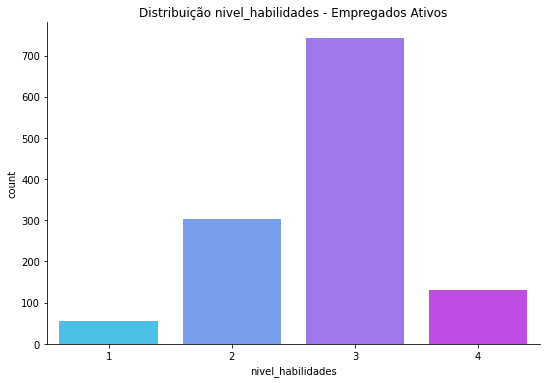

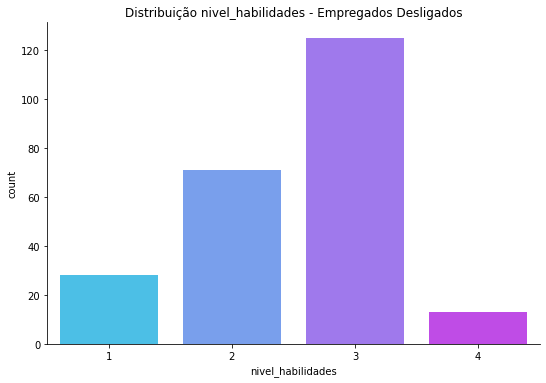

In [45]:
 desc_estats(df=df, tipo='bar', var='nivel_habilidades')

---
### Nível Cargo


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 5
Amplitude - 4
Média - 2.15
Mediana - 2
Moda - 2

Empregados Desligados

Mínimo - 1
Máximo - 5
Amplitude - 4
Média - 1.64
Mediana - 1
Moda - 1

Distribuição dos valores


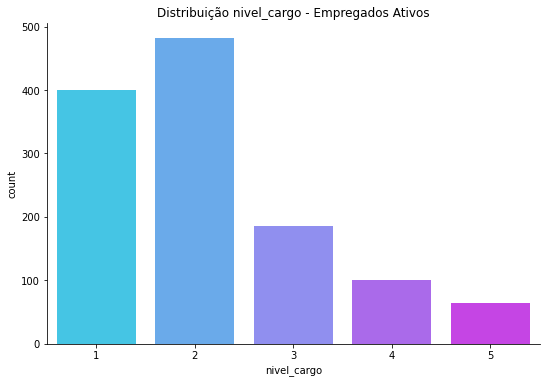

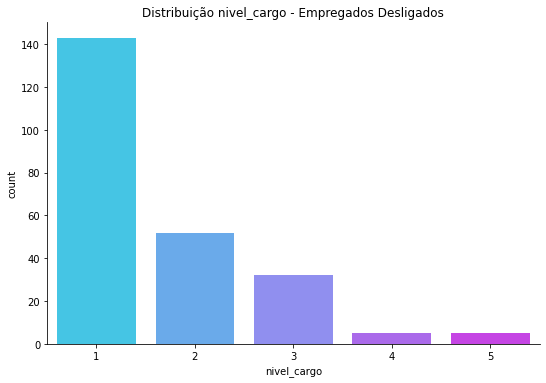

In [46]:
 desc_estats(df=df, tipo='bar', var='nivel_cargo')

---
### Satisfação Cargo


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.78
Mediana - 3
Moda - 4

Empregados Desligados

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.47
Mediana - 3
Moda - 3

Distribuição dos valores


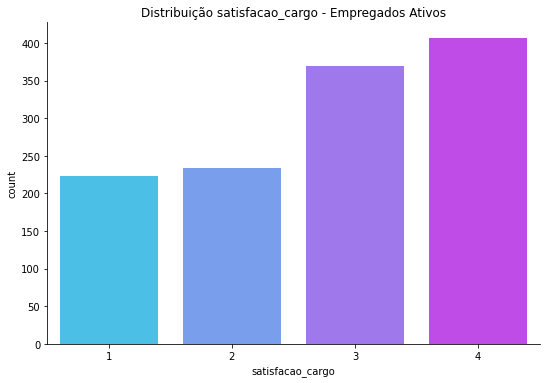

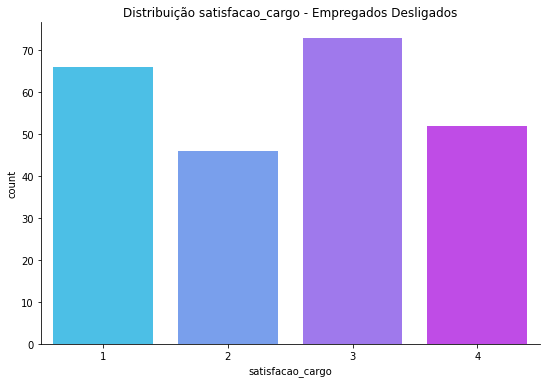

In [47]:
 desc_estats(df=df, tipo='bar', var='satisfacao_cargo')

---
### Salário Mensal


Estatística Descritiva

Empregados Ativos

Mínimo - 1051
Máximo - 19999
Amplitude - 18948
Média - 6832.74
Mediana - 5204
Moda - 4122
Desvio Padrão - 4818.21
Intervalo com 95% de confianca: Inferior -2803.68, Superior 16469.16

Empregados Desligados

Mínimo - 1009
Máximo - 19859
Amplitude - 18850
Média - 4787.09
Mediana - 3202
Moda - 3101
Desvio Padrão - 3640.21
Intervalo com 95% de confianca: Inferior -2493.33, Superior 12067.51

Histograma das Distribuições


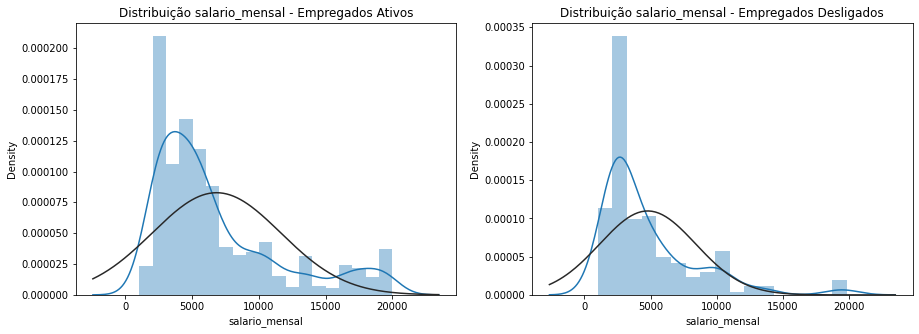


Testes para toda Distribuição

Shapiro Teste Para Determinar a Normalidade
Teste Estatistico - 0.828
P-Value- 0.0

Teste de distorção para determinar a inclinação da curva
Skewness - 1.368

Teste de curtose para determinar a inclinação das extremidades da curva
Kurtosis - 0.998


In [50]:
 desc_estats(df=df, tipo='hist', var='salario_mensal')

---
### Empresas Trabalhadas


Estatística Descritiva

Empregados Ativos

Mínimo - 0
Máximo - 9
Amplitude - 9
Média - 2.65
Mediana - 2
Moda - 1

Empregados Desligados

Mínimo - 0
Máximo - 9
Amplitude - 9
Média - 2.94
Mediana - 1
Moda - 1

Distribuição dos valores


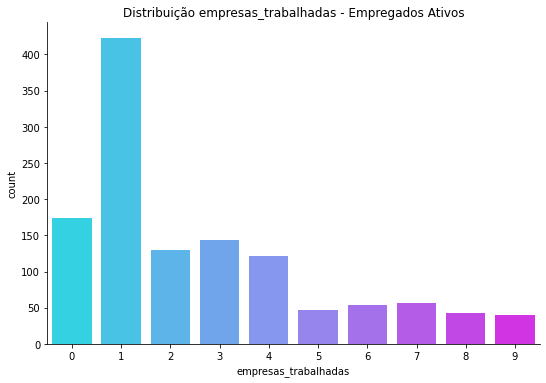

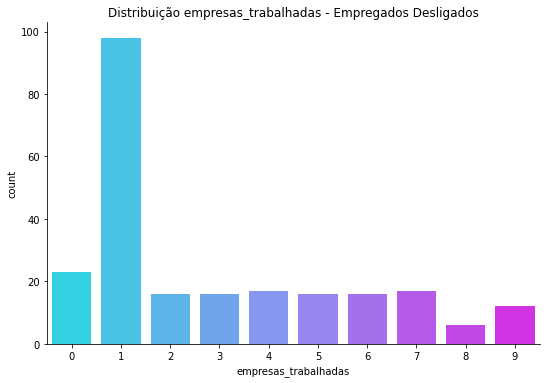

In [51]:
 desc_estats(df=df, tipo='bar', var='empresas_trabalhadas')

---
### Aumento de Salário


Estatística Descritiva

Empregados Ativos

Mínimo - 11
Máximo - 25
Amplitude - 14
Média - 15.23
Mediana - 14
Moda - 14

Empregados Desligados

Mínimo - 11
Máximo - 25
Amplitude - 14
Média - 15.1
Mediana - 14
Moda - 11

Distribuição dos valores


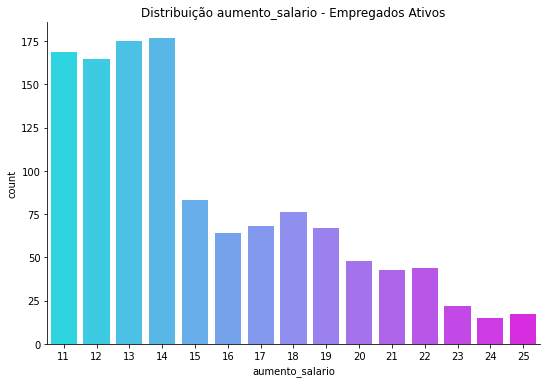

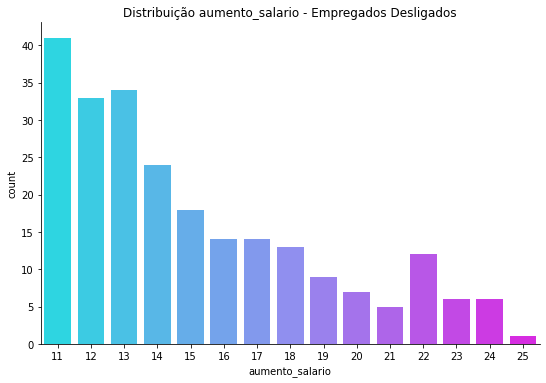

In [52]:
 desc_estats(df=df, tipo='bar', var='aumento_salario')

---
### Avaliação Entregas


Estatística Descritiva

Empregados Ativos

Mínimo - 3
Máximo - 4
Amplitude - 1
Média - 3.15
Mediana - 3
Moda - 3

Empregados Desligados

Mínimo - 3
Máximo - 4
Amplitude - 1
Média - 3.16
Mediana - 3
Moda - 3

Distribuição dos valores


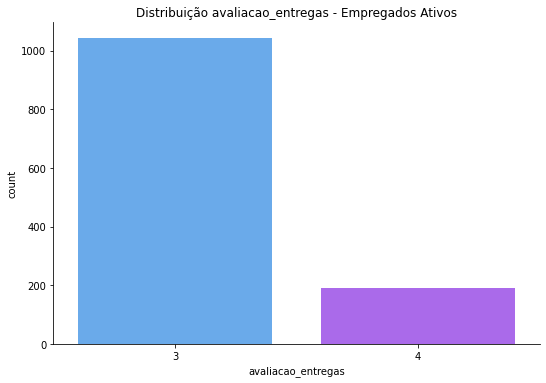

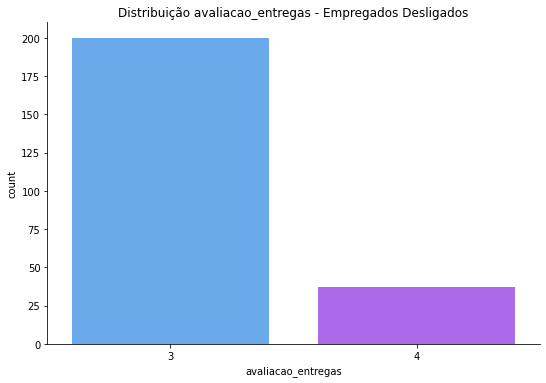

In [53]:
 desc_estats(df=df, tipo='bar', var='avaliacao_entregas')

---
### Satisfação Colegas


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.73
Mediana - 3
Moda - 3

Empregados Desligados

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.6
Mediana - 3
Moda - 3

Distribuição dos valores


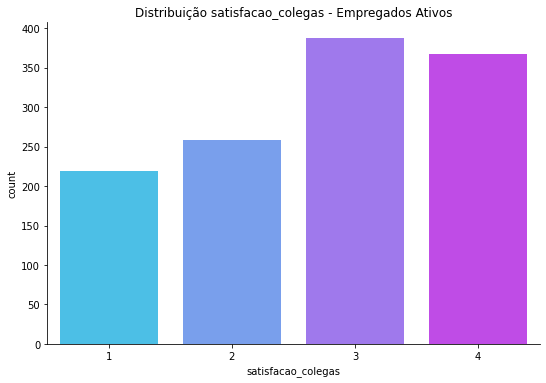

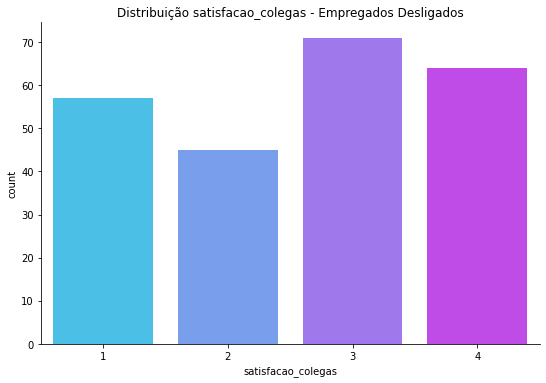

In [54]:
 desc_estats(df=df, tipo='bar', var='satisfacao_colegas')

---
### Ações Empresa


Estatística Descritiva

Empregados Ativos

Mínimo - 0
Máximo - 3
Amplitude - 3
Média - 0.85
Mediana - 1
Moda - 1

Empregados Desligados

Mínimo - 0
Máximo - 3
Amplitude - 3
Média - 0.53
Mediana - 0
Moda - 0

Distribuição dos valores


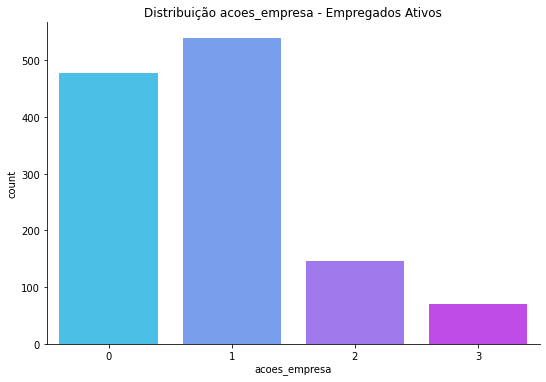

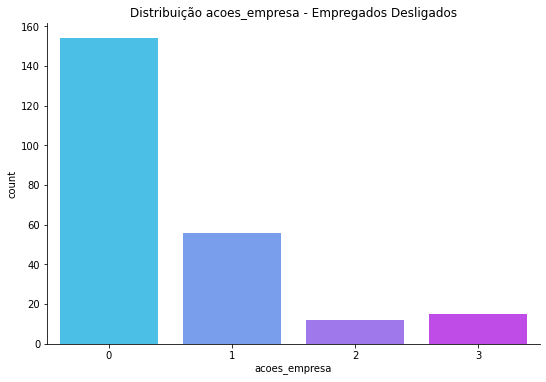

In [55]:
 desc_estats(df=df, tipo='bar', var='acoes_empresa')

---
### Treinamentos no último ano


Estatística Descritiva

Empregados Ativos

Mínimo - 0
Máximo - 6
Amplitude - 6
Média - 2.83
Mediana - 3
Moda - 2

Empregados Desligados

Mínimo - 0
Máximo - 6
Amplitude - 6
Média - 2.62
Mediana - 2
Moda - 2

Distribuição dos valores


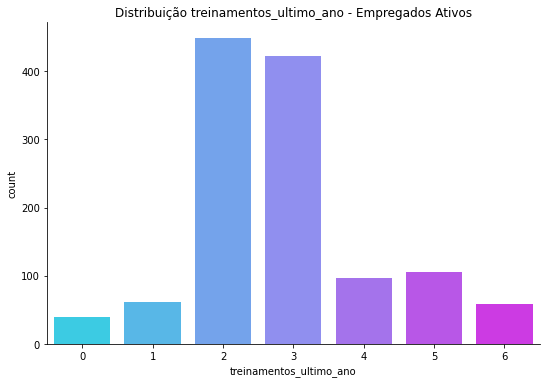

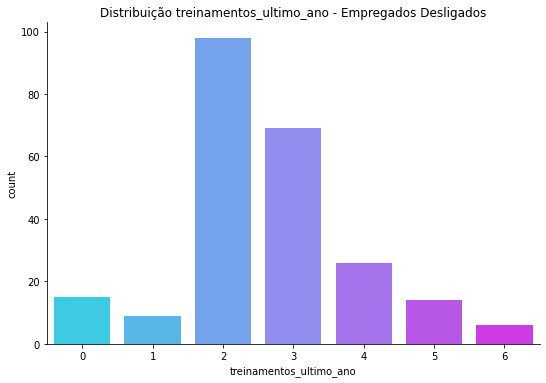

In [56]:
 desc_estats(df=df, tipo='bar', var='treinamentos_ultimo_ano')

---
### Satisfação Qualidade de Vida


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.78
Mediana - 3
Moda - 3

Empregados Desligados

Mínimo - 1
Máximo - 4
Amplitude - 3
Média - 2.66
Mediana - 3
Moda - 3

Distribuição dos valores


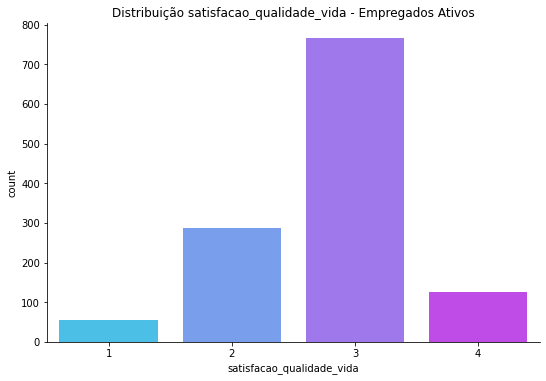

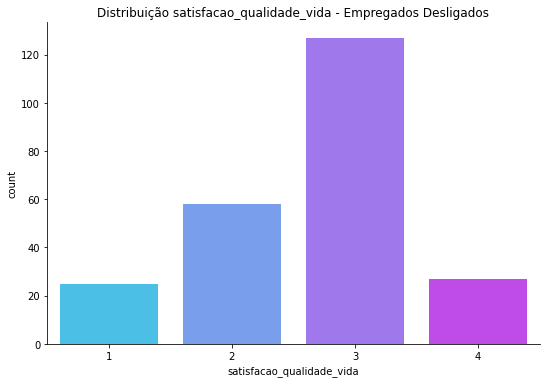

In [57]:
 desc_estats(df=df, tipo='bar', var='satisfacao_qualidade_vida')

---
### Meses na empresa


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 446
Amplitude - 445
Média - 94.34
Mediana - 73
Moda - 66
Desvio Padrão - 73.21
Intervalo com 95% de confianca: Inferior -52.08, Superior 240.75

Empregados Desligados

Mínimo - 1
Máximo - 483
Amplitude - 482
Média - 67.57
Mediana - 46
Moda - 14
Desvio Padrão - 71.73
Intervalo com 95% de confianca: Inferior -75.88, Superior 211.03

Histograma das Distribuições


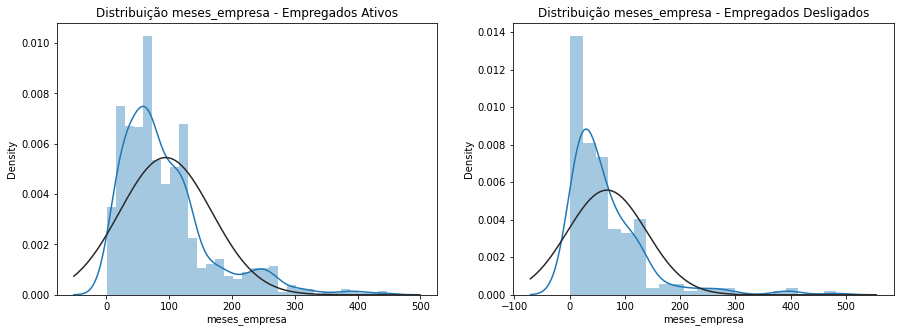


Testes para toda Distribuição

Shapiro Teste Para Determinar a Normalidade
Teste Estatistico - 0.845
P-Value- 0.0

Teste de distorção para determinar a inclinação da curva
Skewness - 1.752

Teste de curtose para determinar a inclinação das extremidades da curva
Kurtosis - 3.891


In [58]:
 desc_estats(df=df, tipo='hist', var='meses_empresa')

---
### Meses na Atual Gerencia


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 215
Amplitude - 214
Média - 58.42
Mediana - 44
Moda - 30
Desvio Padrão - 43.29
Intervalo com 95% de confianca: Inferior -28.16, Superior 145.01

Empregados Desligados

Mínimo - 1
Máximo - 179
Amplitude - 178
Média - 40.39
Mediana - 29
Moda - 7
Desvio Padrão - 37.93
Intervalo com 95% de confianca: Inferior -35.47, Superior 116.25

Histograma das Distribuições


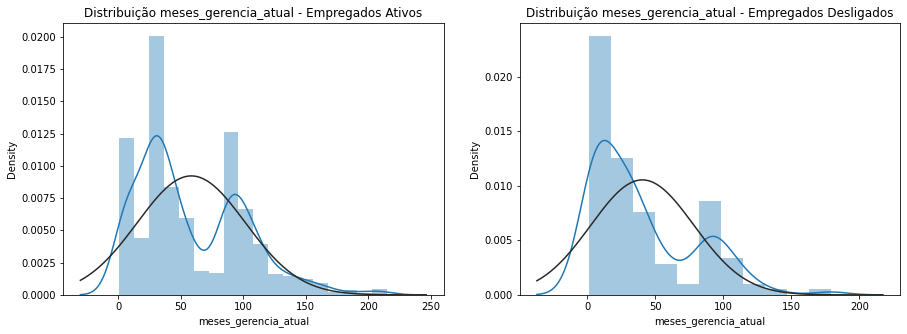


Testes para toda Distribuição

Shapiro Teste Para Determinar a Normalidade
Teste Estatistico - 0.915
P-Value- 0.0

Teste de distorção para determinar a inclinação da curva
Skewness - 0.834

Teste de curtose para determinar a inclinação das extremidades da curva
Kurtosis - 0.183


In [59]:
 desc_estats(df=df, tipo='hist', var='meses_gerencia_atual')

---
### Meses desde a ultima promoção


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 191
Amplitude - 190
Média - 32.67
Mediana - 17
Moda - 3
Desvio Padrão - 38.84
Intervalo com 95% de confianca: Inferior -45.02, Superior 110.36

Empregados Desligados

Mínimo - 1
Máximo - 187
Amplitude - 186
Média - 29.12
Mediana - 15
Moda - 4
Desvio Padrão - 37.75
Intervalo com 95% de confianca: Inferior -46.38, Superior 104.61

Histograma das Distribuições


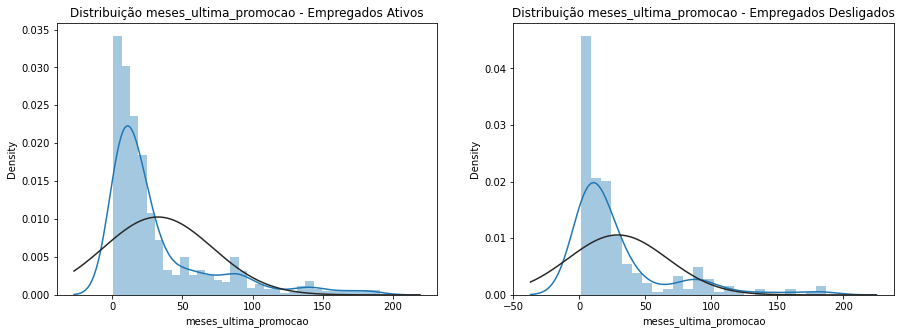


Testes para toda Distribuição

Shapiro Teste Para Determinar a Normalidade
Teste Estatistico - 0.735
P-Value- 0.0

Teste de distorção para determinar a inclinação da curva
Skewness - 1.963

Teste de curtose para determinar a inclinação das extremidades da curva
Kurtosis - 3.539


In [60]:
 desc_estats(df=df, tipo='hist', var='meses_ultima_promocao')

---
### Meses no cargo atual


Estatística Descritiva

Empregados Ativos

Mínimo - 1
Máximo - 219
Amplitude - 218
Média - 59.82
Mediana - 46
Moda - 27
Desvio Padrão - 43.88
Intervalo com 95% de confianca: Inferior -27.93, Superior 147.58

Empregados Desligados

Mínimo - 1
Máximo - 182
Amplitude - 181
Média - 40.71
Mediana - 30
Moda - 2
Desvio Padrão - 38.34
Intervalo com 95% de confianca: Inferior -35.96, Superior 117.39

Histograma das Distribuições


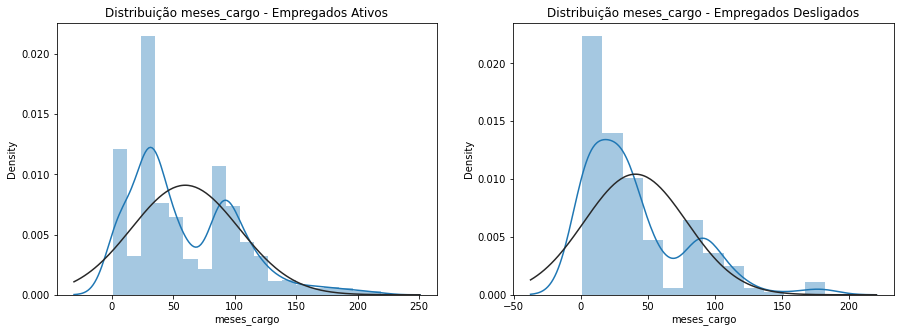


Testes para toda Distribuição

Shapiro Teste Para Determinar a Normalidade
Teste Estatistico - 0.916
P-Value- 0.0

Teste de distorção para determinar a inclinação da curva
Skewness - 0.892

Teste de curtose para determinar a inclinação das extremidades da curva
Kurtosis - 0.413


In [61]:
 desc_estats(df=df, tipo='hist', var='meses_cargo')

---
### Meses trabalhados


Estatística Descritiva

Empregados Ativos

Mínimo - 2
Máximo - 461
Amplitude - 459
Média - 148.32
Mediana - 124
Moda - 124
Desvio Padrão - 93.25
Intervalo com 95% de confianca: Inferior -38.19, Superior 334.82

Empregados Desligados

Mínimo - 1
Máximo - 489
Amplitude - 488
Média - 105.06
Mediana - 88
Moda - 40
Desvio Padrão - 86.33
Intervalo com 95% de confianca: Inferior -67.59, Superior 277.72

Histograma das Distribuições


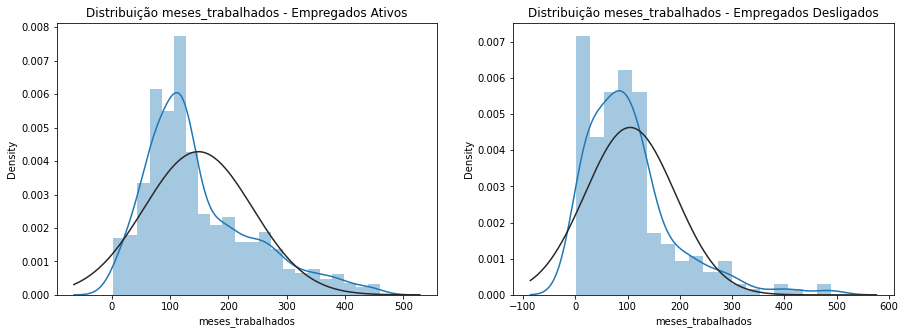


Testes para toda Distribuição

Shapiro Teste Para Determinar a Normalidade
Teste Estatistico - 0.91
P-Value- 0.0

Teste de distorção para determinar a inclinação da curva
Skewness - 1.115

Teste de curtose para determinar a inclinação das extremidades da curva
Kurtosis - 0.921


In [62]:
 desc_estats(df=df, tipo='hist', var='meses_trabalhados')

## Analisando as Features Qualitativas do DataFrame

---
### Genero


Distribuição dos valores


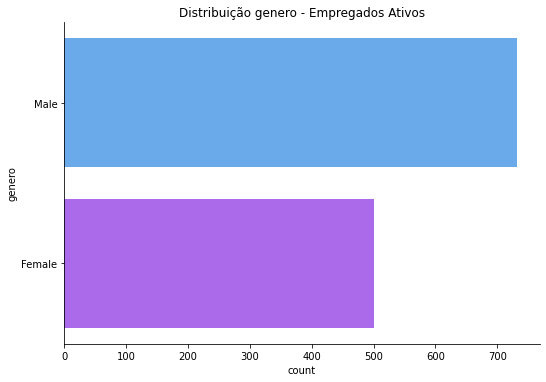

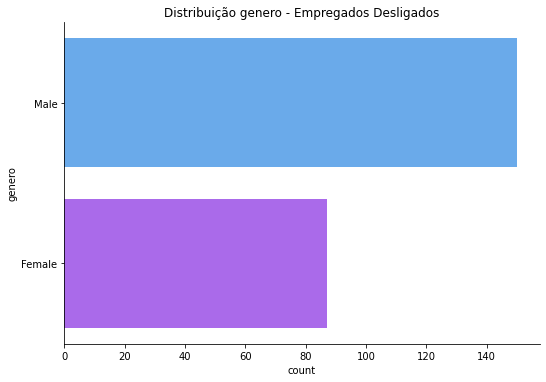

In [86]:
desc_quali(df=df, var='genero')

---
### Cargos


Distribuição dos valores


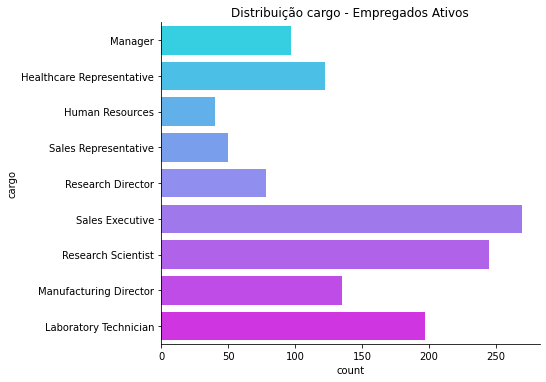

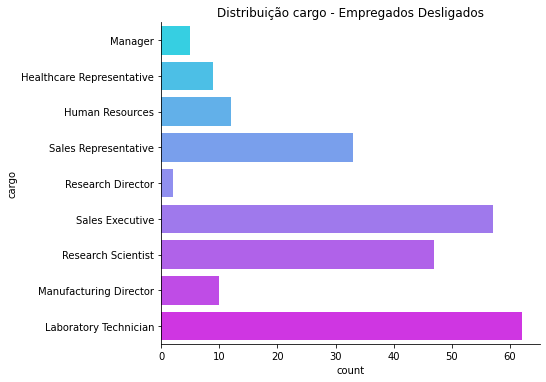

In [87]:
desc_quali(df=df, var='cargo')

---
### Estado Civil


Distribuição dos valores


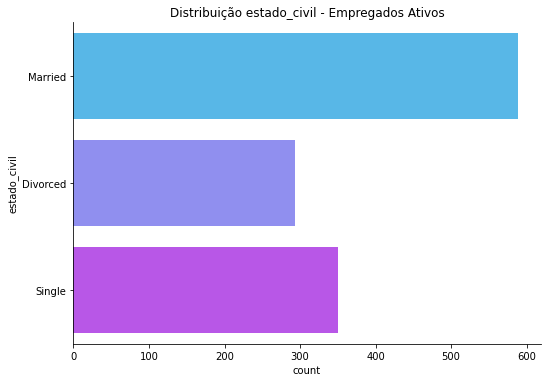

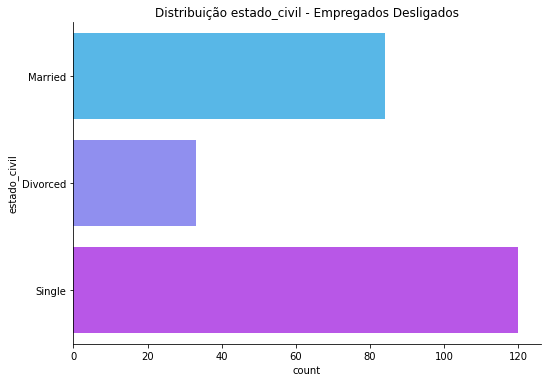

In [88]:
desc_quali(df=df, var='estado_civil')

---
### Hora Extra


Distribuição dos valores


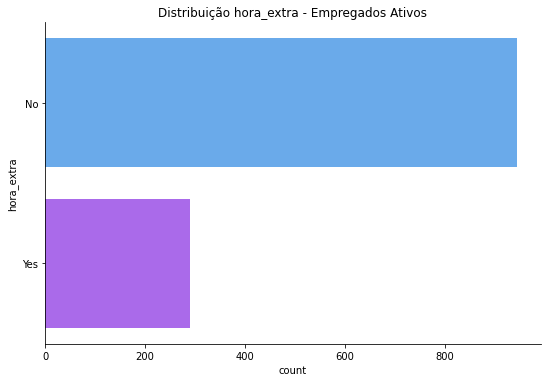

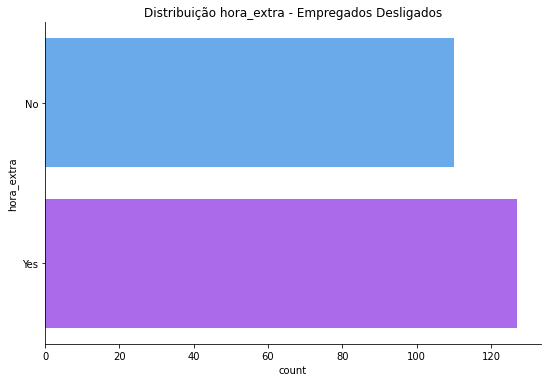

In [89]:
desc_quali(df=df, var='hora_extra')

---
### Campo Educação


Distribuição dos valores


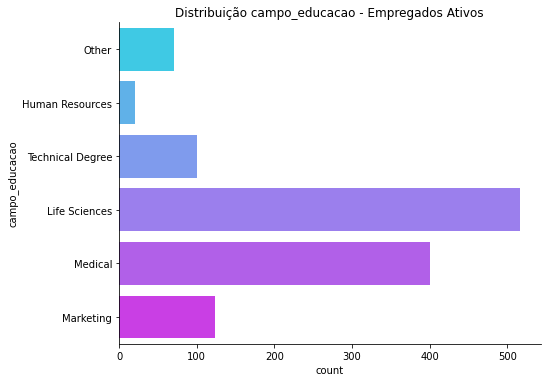

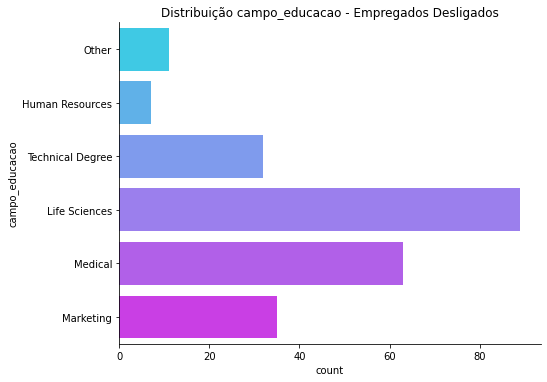

In [90]:
desc_quali(df=df, var='campo_educacao')

---
### Varivavel Dependente - Desligamento


Distribuição dos valores


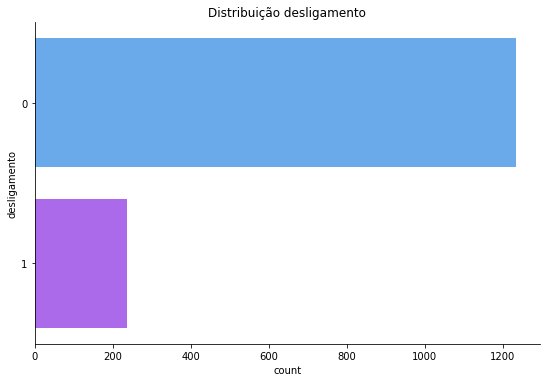


Distribuição dos valores tabela
0    1233
1     237
Name: desligamento, dtype: int64


In [92]:
desc_quali_target(df=df, var='desligamento')

## Correlação Entre as variáveis e o Target

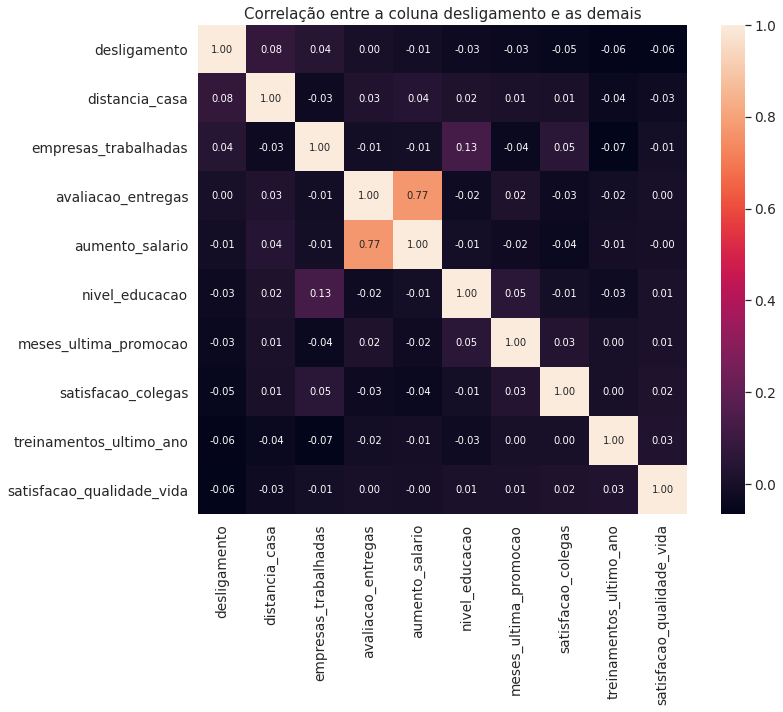

In [95]:
#Response correlation matrix
corrmat = df.corr()
k = 10 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))
cols = corrmat.nlargest(k, 'desligamento')['desligamento'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)

hm = sns.heatmap(cm, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=cols.values, 
                 xticklabels=cols.values)
plt.title('Correlação entre a coluna desligamento e as demais')
plt.show()

## Modelando Dados para identificar as Features mais importantes

### Hot Encoding

In [98]:
df_hc = pd.get_dummies(df)

### Separando dados em X e y

In [99]:
X = df_hc.drop(['desligamento'], axis=1)
y = df_hc['desligamento']

### Seperando em conjunto de treino e teste utilizando cross validation de 10 folds

### Treinando Modelo com dados não balanceados

In [100]:
model = RandomForestClassifier()
model.fit(X, y)
print('****Results****')
print("Accuracy:", cross_val_score(model, X, y, cv=10, scoring='accuracy').mean())
print("Precision:", cross_val_score(model, X, y, cv=10, scoring='precision').mean())
print("Recall:", cross_val_score(model, X, y, cv=10, scoring='recall').mean())
print("F1 Score:", cross_val_score(model, X, y, cv=10, scoring='f1').mean())
print("Roc Auc", cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())

****Results****
Accuracy: 0.863265306122449
Precision: 0.8178571428571428
Recall: 0.1940217391304348
F1 Score: 0.26200402563695113
Roc Auc 0.8095149317552082


### Treinando Modelos com dados balanceados

In [101]:
#Balanceando dados utilizando Smote
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

#Criando um dataset com os dados balanceados
df_balanced = X.copy()
df_balanced['desligamento'] = y

In [103]:
model = RandomForestClassifier()
model.fit(X, y)

print('****Results****')
print("Accuracy:", cross_val_score(model, X, y, cv=10, scoring='accuracy').mean())
print("Precision:", cross_val_score(model, X, y, cv=10, scoring='precision').mean())
print("Recall:", cross_val_score(model, X, y, cv=10, scoring='recall').mean())
print("F1 Score:", cross_val_score(model, X, y, cv=10, scoring='f1').mean())
print("Roc Auc", cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())

****Results****
Accuracy: 0.9307412527566573
Precision: 0.9718375233497021
Recall: 0.8894702334120115
F1 Score: 0.9152162256346417
Roc Auc 0.985499382727895


### Identificando as Features mais significativas do modelo

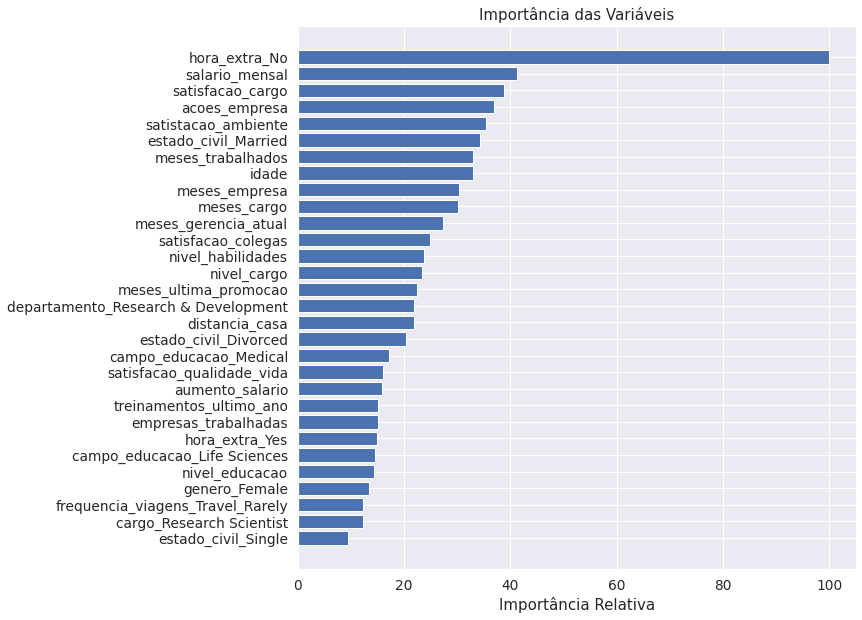

In [104]:
feature_importance = model.feature_importances_
limite = 30

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-limite:]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Importância Relativa')
plt.title('Importância das Variáveis')
plt.show()

## Utilizando Analise de sobrevicência para estimar o período até o desligamento

### Comparando tempo de empresa de funcionários ativos vs desligados

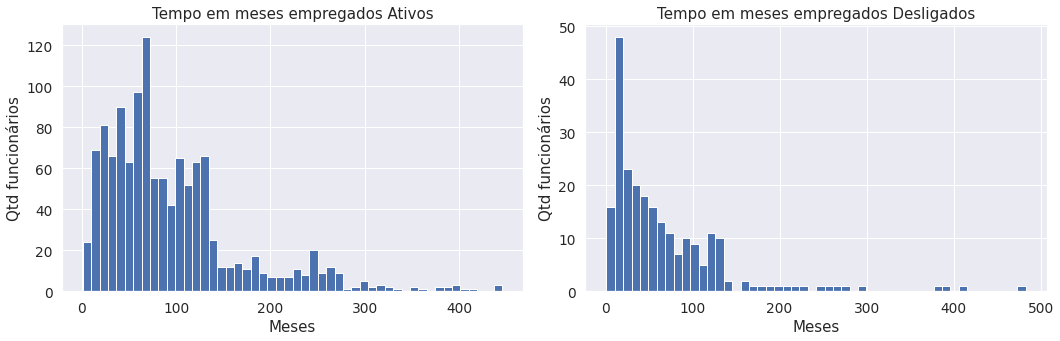

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
ax1 = df["meses_empresa"][df["desligamento"]==0].hist(bins=50, ax=axes[0])
ax2 =df["meses_empresa"][df["desligamento"]==1].hist(bins=50, ax=axes[1])


ax1.set_title('Tempo em meses empregados Ativos')
ax1.set_xlabel("Meses")
ax1.set_ylabel("Qtd funcionários")
ax2.set_title('Tempo em meses empregados Desligados')
ax2.set_xlabel("Meses")
ax2.set_ylabel("Qtd funcionários")
fig.tight_layout()

## Criando Função para calcular a probabilidade em um período de tempo

In [108]:
naf = NelsonAalenFitter()
naf.fit(df_balanced["meses_empresa"], event_observed=df_balanced['desligamento'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 2466 total observations, 1233 right-censored observations>

### Probabilidade Acumulada

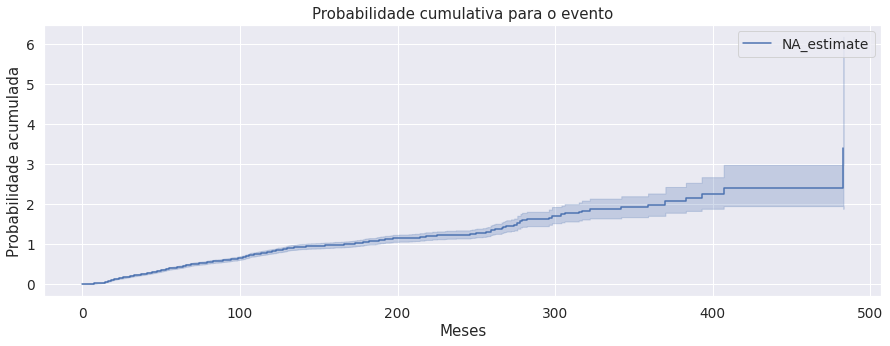

In [113]:
#Plot the cumulative hazard graph
plt.figure(figsize=(15,5))
naf.plot_cumulative_hazard()
plt.title("Probabilidade cumulativa para o evento")
plt.xlabel("Meses")
plt.ylabel("Probabilidade acumulada")
plt.show()

In [114]:
#Predict a value at a certain point
print("Tempo = 12 meses: ", naf.predict(12))
print("Tempo = 24 meses: ", naf.predict(24))
print("Tempo = 36 meses: ", naf.predict(36))
print("Tempo = 50 meses: ", naf.predict(50))
print("Tempo = 100 meses: ", naf.predict(100))
print("Tempo = 150 meses: ", naf.predict(150))

Tempo = 12 meses:  0.028155298659889638
Tempo = 24 meses:  0.14737411619879737
Tempo = 36 meses:  0.23441058903812007
Tempo = 50 meses:  0.33720995967532374
Tempo = 100 meses:  0.6486029383261203
Tempo = 150 meses:  0.9495705011301405


## Análise baseada em Genero

In [121]:
df_female = df_balanced[df_balanced["genero_Female"]==1]
df_male = df_balanced[df_balanced["genero_Male"]==1]

In [122]:
#Create an objetct of NelsonAslenFitter
naf_female = NelsonAalenFitter()
naf_male = NelsonAalenFitter()

In [123]:
#Fit our data into the objetc
naf_female.fit(df_female["meses_empresa"], event_observed=df_female["desligamento"])
naf_male.fit(df_male["meses_empresa"], event_observed=df_male["desligamento"])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 1294 total observations, 732 right-censored observations>

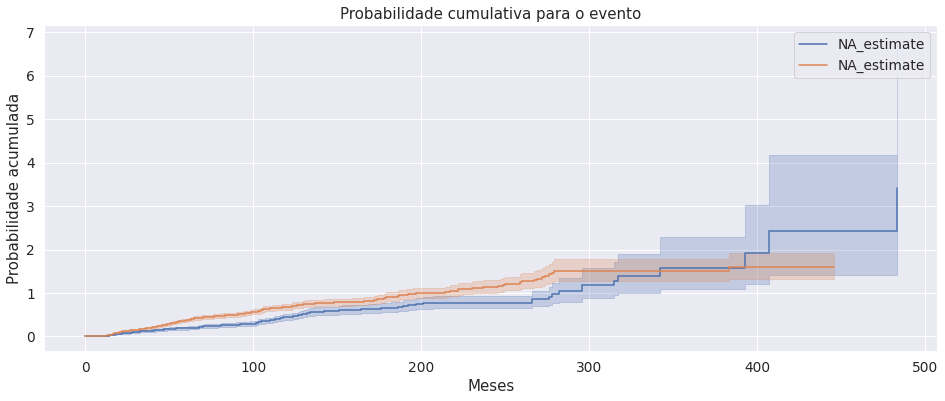

In [124]:
#Plot the cumulative hazard graph
plt.figure(figsize=(16,6))
naf_female.plot_cumulative_hazard()
naf_male.plot_cumulative_hazard()
plt.title("Probabilidade cumulativa para o evento")
plt.xlabel("Meses")
plt.ylabel("Probabilidade acumulada")
plt.show()

In [450]:
#Predict a value at a certain point
print("Tempo = 12 meses: ", naf_male.predict(12))
print("Tempo = 24 meses: ", naf_male.predict(24))
print("Tempo = 36 meses: ", naf_male.predict(36))
print("Tempo = 100 meses: ", naf_male.predict(100))
print("Tempo = 150 meses: ", naf_male.predict(150))

Tempo = 12 meses:  0.0349065006945386
Tempo = 24 meses:  0.14170391115772052
Tempo = 36 meses:  0.19692981280396626
Tempo = 100 meses:  0.5846190807750808
Tempo = 150 meses:  0.8129004102217898


In [451]:
#Predict a value at a certain point
print("Tempo = 12 meses: ", naf_female.predict(12))
print("Tempo = 24 meses: ", naf_female.predict(24))
print("Tempo = 36 meses: ", naf_female.predict(36))
print("Tempo = 100 meses: ", naf_female.predict(100))
print("Tempo = 150 meses: ", naf_female.predict(150))

Tempo = 12 meses:  0.008324258863758871
Tempo = 24 meses:  0.08305150970389885
Tempo = 36 meses:  0.13090293955261778
Tempo = 100 meses:  0.2998599181381367
Tempo = 150 meses:  0.6024227612308835


## Análise Baseada em Hora Extra

In [115]:
df_hs = df_balanced[df_balanced["hora_extra_Yes"]==1]
df_hn = df_balanced[df_balanced["hora_extra_No"]==1]

In [116]:
#Create an objetct of NelsonAslenFitter
naf_hs = NelsonAalenFitter()
naf_hn = NelsonAalenFitter()

In [117]:
#Fit our data into the objetc
naf_hs.fit(df_hs["meses_empresa"], event_observed=df_hs["desligamento"])
naf_hn.fit(df_hn["meses_empresa"], event_observed=df_hn["desligamento"])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 1304 total observations, 944 right-censored observations>

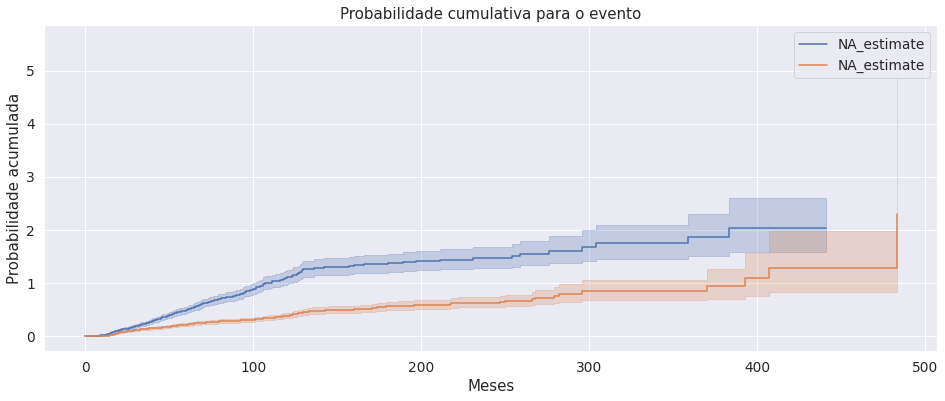

In [119]:
#Plot the cumulative hazard graph
plt.figure(figsize=(16,6))
naf_hs.plot_cumulative_hazard()
naf_hn.plot_cumulative_hazard()
plt.title("Probabilidade cumulativa para o evento")
plt.xlabel("Meses")
plt.ylabel("Probabilidade acumulada")
plt.show()

In [465]:
#Predict a value at a certain point
print("Tempo = 12 meses: ", naf_hs.predict(12))
print("Tempo = 24 meses: ", naf_hs.predict(24))
print("Tempo = 36 meses: ", naf_hs.predict(36))
print("Tempo = 100 meses: ", naf_hs.predict(100))
print("Tempo = 150 meses: ", naf_hs.predict(150))

Tempo = 12 meses:  0.03810462147066129
Tempo = 24 meses:  0.1663277250395332
Tempo = 36 meses:  0.2636105812924159
Tempo = 100 meses:  0.8880133094071914
Tempo = 150 meses:  1.2615524996206817


In [466]:
#Predict a value at a certain point
print("Tempo = 12 meses: ", naf_hn.predict(12))
print("Tempo = 24 meses: ", naf_hn.predict(24))
print("Tempo = 36 meses: ", naf_hn.predict(36))
print("Tempo = 100 meses: ", naf_hn.predict(100))
print("Tempo = 150 meses: ", naf_hn.predict(150))

Tempo = 12 meses:  0.015058300411306291
Tempo = 24 meses:  0.08162161865630502
Tempo = 36 meses:  0.1319911787335446
Tempo = 100 meses:  0.2836815212270034
Tempo = 150 meses:  0.48444083031522744


### Análise baseada em Idade

In [126]:
df_30_mais = df_balanced[df_balanced["idade"]>30]
df_30_menos = df_balanced[df_balanced["idade"]<=30]

In [127]:
#Create an objetct of NelsonAslenFitter
naf_30_mais = NelsonAalenFitter()
naf_30_menos = NelsonAalenFitter()

In [128]:
#Fit our data into the objetc
naf_30_mais.fit(df_30_mais["meses_empresa"], event_observed=df_30_mais["desligamento"])
naf_30_menos.fit(df_30_menos["meses_empresa"], event_observed=df_30_menos["desligamento"])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 824 total observations, 286 right-censored observations>

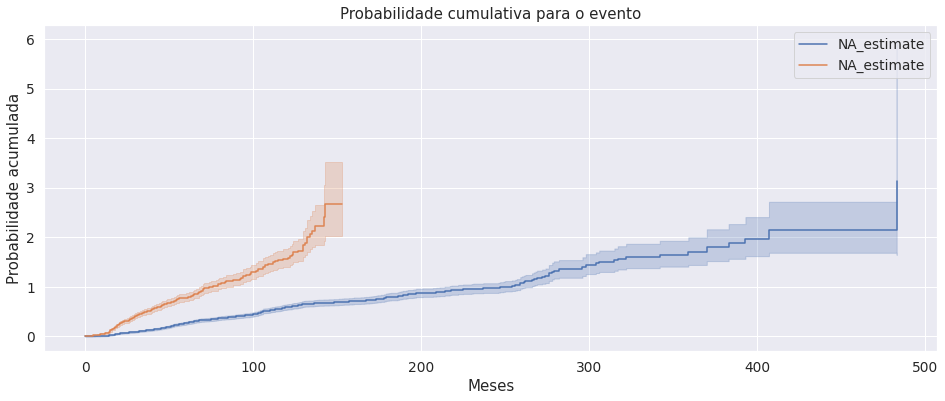

In [130]:
#Plot the cumulative hazard graph
plt.figure(figsize=(16,6))
naf_30_mais.plot_cumulative_hazard()
naf_30_menos.plot_cumulative_hazard()
plt.title("Probabilidade cumulativa para o evento")
plt.xlabel("Meses")
plt.ylabel("Probabilidade acumulada")
plt.show()

In [502]:
#Predict a value at a certain point
print("Tempo = 12 meses: ", naf_30_mais.predict(12))
print("Tempo = 24 meses: ", naf_30_mais.predict(24))
print("Tempo = 36 meses: ", naf_30_mais.predict(36))
print("Tempo = 100 meses: ", naf_30_mais.predict(100))
print("Tempo = 150 meses: ", naf_30_mais.predict(150))

Tempo = 12 meses:  0.012309646111193118
Tempo = 24 meses:  0.07358932845427191
Tempo = 36 meses:  0.12598184019229475
Tempo = 100 meses:  0.45482826802224796
Tempo = 150 meses:  0.7461432035495372


In [503]:
#Predict a value at a certain point
print("Tempo = 12 meses: ", naf_30_menos.predict(12))
print("Tempo = 24 meses: ", naf_30_menos.predict(24))
print("Tempo = 36 meses: ", naf_30_menos.predict(36))
print("Tempo = 100 meses: ", naf_30_menos.predict(100))
print("Tempo = 150 meses: ", naf_30_menos.predict(150))

Tempo = 12 meses:  0.07527068706362705
Tempo = 24 meses:  0.33587267994077763
Tempo = 36 meses:  0.50442672032018
Tempo = 100 meses:  1.3029483682853167
Tempo = 150 meses:  2.6660788818023544
